In [17]:
import os, warnings
import dicom
import numpy as np
from matplotlib import pyplot, cm
import vtk
from vtk.util import numpy_support
  
lidc_path = "/home/felipecdo/medical-imaging/images-TCIA/downloaded-images/DOI/"

class LidcSeries:
    patient =""
    study=""
    series=""
    folder_path=""
    xml_path=""
    dicom_image_paths=[]
    
    def set_xml_info(self,xml_info):
        self.xml_info = xml_info
    def set_image_paths(self,image_paths):
        self.dicom_image_paths = sorted(image_paths)
    def __str__(self):
        return folder_path
    
    def read_dicom_image(self, position):
        with open(self.dicom_image_paths[position], 'rb') as f:
            return dicom.read_file(f)
        


def get_dicom_paths(path_study, verbose=True):
    folders = []
    for folder_item in os.listdir(path_study):
        if folder_item.endswith('.dcm'):
            path_to_dicom = os.path.join(path_study, folder_item)
            folders.append(path_to_dicom )
    return folders
    
def get_xml_path(path_study, verbose=True):
    for folder_item in os.listdir(path_study):
        if folder_item.endswith('.xml'):
            return os.path.join(path_study, folder_item)

def load_series(lidc_path, verbose=True):
    """
    Load all the DICOM images assocated with this scan and return as list.

    Example:
        >>> scan = pl.query(pl.Scan).first()
        >>> images = scan.load_all_dicom_images()
        >>> zs = [float(img.ImagePositionPatient[2]) for img in images]
        >>> print(zs[1] - zs[0], img.SliceThickness, scan.slice_thickness)
        >>>
        >>> import matplotlib.pyplot as plt
        >>> plt.imshow( images[0].pixel_array, cmap=plt.cm.gray )
        >>> plt.show()
    """
    if verbose: print("Loading dicom files ... This may take a moment.")

    path = lidc_path
    
    #"/patient_id/study_instance_uid/series_instance_uid"
    all_series = []
    
    for patient in os.listdir(path):
        for study in os.listdir(os.path.join(path,patient)):
            for series in os.listdir(os.path.join(path, patient, study)):
                lidcSerie = LidcSeries()
                current_path = os.path.join(path, patient, study, series)
                folders = get_dicom_paths(current_path)        
                xml_path = get_xml_path(current_path)        

                lidcSerie.patient = patient
                lidcSerie.study = study
                lidcSerie.series = series
                lidcSerie.xml_path = xml_path
                lidcSerie.set_image_paths(folders)
                all_series.append(lidcSerie)
    
    if verbose: print("Series Count: " + str(len(all_series)))
    
    if verbose: print len(all_series[0].dicom_image_paths)
    if verbose: print len(all_series[1].dicom_image_paths)
    if verbose: print len(all_series[2].dicom_image_paths)
    if verbose: print len(all_series[7].dicom_image_paths)
    
    return all_series


series = load_series(lidc_path)

Loading dicom files ... This may take a moment.
Series Count: 1257
2
129
130
4


In [36]:
# Based on https://github.com/zhwhong/lidc_nodule_detection/blob/master/api_lidc/nodule_structs.py

class NoduleCharacteristics:
    def __init__(self):
        self.subtlety = 0
        self.internal_struct = 0
        self.calcification = 0
        self.sphericity = 0
        self.margin = 0
        self.lobulation = 0
        self.spiculation = 0
        self.texture = 0
        self.malignancy = 0
        return

    def __str__(self):
        str = "subtlty (%d) intstruct (%d) calci (%d) sphere (%d) " \
              "margin (%d) lob (%d) spicul (%d) txtur (%d) malig (%d)" % (
                  self.subtlety, self.internal_struct, self.calcification,
                  self.sphericity,
                  self.margin, self.lobulation, self.spiculation, self.texture,
                  self.malignancy)
        return str

    def set_values(self, sub, inter, calc, spher, lob, spic, tex, malig):
        self.subtlety = sub
        self.internal_struct = inter
        self.calcification = calc
        self.sphericity = spher
        self.lobulation = lob
        self.spiculation = spic
        self.texture = tex
        self.malignancy = malig
        return


class NoduleRoi:  # is common for nodule and non-nodule
    def __init__(self, z_pos=0., sop_uid=''):
        self.z = z_pos
        self.sop_uid = sop_uid
        self.inclusion = True

        self.roi_xy = []  # to hold list of x,ycords in edgemap(edgmap pairs)
        self.roi_rect = []  # rectangle to hold the roi
        self.roi_centroid = []  # to hold centroid of the roi
        return

    def __str__(self):
        n_pts = len(self.roi_xy)
        str = "Inclusion (%s) Z = %.2f SOP_UID (%s) \n ROI points [ %d ]  ::  " \
              "" % (
            self.inclusion, self.z, self.sop_uid, n_pts)

        if (n_pts > 2):
            str += "[[ %d,%d ]] :: " % (
            self.roi_centroid[0], self.roi_centroid[1])
            str += "(%d, %d), (%d,%d)..." % (
                self.roi_xy[0][0], self.roi_xy[0][1], self.roi_xy[1][0],
                self.roi_xy[1][1])
            str += "(%d, %d), (%d,%d)" % (
                self.roi_xy[-2][0], self.roi_xy[-2][1], self.roi_xy[-1][0],
                self.roi_xy[-1][1])
        else:
            for i in range(n_pts):
                str += "(%d, %d)," % (self.roi_xy[i][0], self.roi_xy[i][1])
        return str


class Nodule:  # is base class for all nodule types (NormalNodule,
    # SmallNodule, NonNodule)
    def __init__(self):
        self.id = None
        self.rois = []
        self.is_small = False

    def __str__(self):
        strng = "--- Nodule ID (%s) Small [%s] ---\n" % (
        self.id, str(self.is_small))
        strng += self.tostring() + "\n"
        return strng

    def tostring(self):
        pass


class NoduleAnnotationCluster():  # to be seen
    def __init__(self):
        self.id = []
        self.z_pos = []
        self.centroid = []  # (x,y) of the centroid
        #  convex hull description
        #   p0 ---- p1
        #   |       |
        #   p2-----p3
        self.convex_hull = []  # [()_0 ()_1 ()_2 ()_3]
        self.convex_hull_with_margin = []
        self.no_annots = 0
        self.nodules_data = []

    def compute_centroid(self):
        self.set_convex_hull()
        xc = 0.5 * (
        self.convex_hull[0][0] + self.convex_hull[3][0])  # (x_min + x_max)/2
        yc = 0.5 * (
        self.convex_hull[0][1] + self.convex_hull[3][1])  # (y_min + y_max)/2
        self.centroid = (xc, yc)
        return self.centroid

    def set_convex_hull(self):
        x_min, x_max = 640, 0
        y_min, y_max = 640, 0

        for nodule in self.nodules_data:
            for roi in nodule.rois:
                for dt_pt in roi.roi_xy:
                    # roi.roi_xy -> [(x,y)]
                    # TODO : finish this loop  #?????????????????????????????
                    x_min = dt_pt[0] if (x_min > dt_pt[0]) else x_min
                    x_max = dt_pt[0] if (x_max < dt_pt[0]) else x_max
                    y_min = dt_pt[1] if (y_min > dt_pt[1]) else y_min
                    y_max = dt_pt[1] if (y_max < dt_pt[1]) else y_max
        self.convex_hull = [(x_min, y_min), (x_max, y_min), (x_min, y_max),
                            (x_max, y_max)]
        w, h = (x_max - x_min), (y_max - y_min)
        x_min = int(x_min - 0.15 * w)
        x_max = int(x_max + 0.15 * w)
        y_min = int(y_min - 0.15 * h)
        y_max = int(y_max + 0.15 * h)
        self.convex_hull_with_margin = [(x_min, y_min), (x_max, y_min),
                                        (x_min, y_max),
                                        (x_max, y_max)]


class NormalNodule(Nodule):
    def __init__(self):
        Nodule.__init__(self)
        self.characteristics = NoduleCharacteristics()
        self.is_small = False

    def tostring(self):
        strng = str(self.characteristics)
        strng += "\n"

        for roi in self.rois:
            strng += str(
                roi) + "\n"  # str calls __str__ of NoduleRoi's class
            # i.e.converting roi to
        return strng  # string to prepare it for printing(it doesn't print it)


class SmallNodule(Nodule):
    def __init__(self):
        Nodule.__init__(self)
        self.is_small = True

    def tostring(self):
        strng = ''
        for roi in self.rois:
            strng += str(roi) + "\n"
        return strng


class NonNodule(Nodule):
    def __init__(self):
        Nodule.__init__(self)
        self.is_small = True

    def tostring(self):
        strng = ''
        for roi in self.rois:
            strng += str(roi)
        return strng


class RadAnnotation:
    def __init__(self, init=True):
        self.version = None
        self.id = None

        self.nodules = []  # is normalNodule i.e in xml unblindedReadNodule
        # with characteristics info
        self.non_nodules = []  # located inside readingSession
        self.initialized = init
        return

    def is_init(self):
        return self.initialized

    def set_init(self, init):
        self.initialized = init
        return

    def __str__(self):
        n_nodules = len(self.nodules)
        n_non_nodules = len(self.non_nodules)
        strng = "Annotation Version [%s] Radiologist ID [%s] \n" % (
        self.version, self.id)
        strng += "#Nodules [%d] #NonNodules[%d] \n" % (
            n_nodules, n_non_nodules)

        if (n_nodules > 0):
            strng += "--- Nodules [%d]---\n" % n_nodules
            for i in range(n_nodules):
                strng += str(self.nodules[i])

        if (n_non_nodules > 0):
            strng += "--- Non Nodules [%d] ---\n" % n_non_nodules
            for i in range(n_non_nodules):
                strng += str(self.non_nodules[i])

        strng += "-" * 79 + "\n"
        return strng


class IdriReadMessage:
    def __init__(self):
        self.header = AnnotationHeader()
        self.annotations = []

class AnnotationHeader:
    def __init__(
            self):  # 4 elements are not included b/c they don't have data
        # inside
        self.version = None
        self.message_id = None
        self.date_request = None
        self.time_request = None
        self.task_desc = None
        self.series_instance_uid = None
        self.date_service = None
        self.time_service = None
        self.study_instance_uid = None

    def __str__(self):
        str = ("--- XML HEADER ---\n"
               "Version (%s) Message-Id (%s) Date-request (%s) Time-request ("
               "%s) \n"
               "Series-UID (%s)\n"
               "Time-service (%s) Task-descr (%s) Date-service (%s) "
               "Time-service (%s)\n"
               "Study-UID (%s)") % (
                  self.version, self.message_id, self.date_request,
                  self.time_request,
                  self.series_instance_uid, self.time_service, self.task_desc,
                  self.date_service,
                  self.time_service, self.study_instance_uid)
        return str


In [37]:
import xml.etree.ElementTree as ET

NS = {'nih': 'http://www.nih.gov'}

def parse_nodule(xml_node):  # xml_node is one unblindedReadNodule
    char_node = xml_node.find('nih:characteristics', NS)
    # if no characteristics, it is smallnodule  i.e. is_small=TRUE
    is_small = (char_node is None or len(char_node) == 0)
    nodule = is_small and SmallNodule() or NormalNodule()
    nodule.id = xml_node.find('nih:noduleID', NS).text
    if not is_small:
        subtlety = char_node.find('nih:subtlety', NS)
        nodule.characteristics.subtlety = int(subtlety.text)
        nodule.characteristics.internal_struct = \
            int(char_node.find('nih:internalStructure', NS).text)
        nodule.characteristics.calcification = \
            int(char_node.find('nih:calcification', NS).text)
        nodule.characteristics.sphericity = \
            int(char_node.find('nih:sphericity', NS).text)
        nodule.characteristics.margin = \
            int(char_node.find('nih:margin', NS).text)
        nodule.characteristics.lobulation = \
            int(char_node.find('nih:lobulation', NS).text)
        nodule.characteristics.spiculation = \
            int(char_node.find('nih:spiculation', NS).text)
        nodule.characteristics.texture = \
            int(char_node.find('nih:texture', NS).text)
        nodule.characteristics.malignancy = \
            int(char_node.find('nih:malignancy', NS).text)
    xml_rois = xml_node.findall('nih:roi', NS)
    for xml_roi in xml_rois:
        roi = NoduleRoi()
        roi.z = float(xml_roi.find('nih:imageZposition', NS).text)
        roi.sop_uid = xml_roi.find('nih:imageSOP_UID', NS).text
        # when inclusion = TRUE ->roi includes the whole nodule
        # when inclusion = FALSE ->roi is drown twice for one nodule
        # 1.ouside the nodule
        # 2.inside the nodule -> to indicate that the nodule has donut
        # hole(the inside hole is
        # not part of the nodule) but by forcing inclusion to be TRUE,
        # this situation is ignored
        roi.inclusion = (xml_roi.find('nih:inclusion', NS).text == "TRUE")
        edge_maps = xml_roi.findall('nih:edgeMap', NS)
        for edge_map in edge_maps:
            x = int(edge_map.find('nih:xCoord', NS).text)
            y = int(edge_map.find('nih:yCoord', NS).text)
            roi.roi_xy.append([x, y])
        xmax = np.array(roi.roi_xy)[:, 0].max()
        xmin = np.array(roi.roi_xy)[:, 0].min()
        ymax = np.array(roi.roi_xy)[:, 1].max()
        ymin = np.array(roi.roi_xy)[:, 1].min()
        if not is_small:  # only for normalNodules
            roi.roi_rect = (xmin, ymin, xmax, ymax)
            roi.roi_centroid = (
                (xmax + xmin) / 2., (ymin + ymax) / 2.)  # center point
        nodule.rois.append(roi)
    return nodule  # is equivalent to unblindedReadNodule(xml element)


def parse_non_nodule(xml_node):  # xml_node is one nonNodule
    nodule = NonNodule()
    nodule.id = xml_node.find('nih:nonNoduleID', NS).text
    roi = NoduleRoi()
    roi.z = float(xml_node.find('nih:imageZposition', NS).text)
    roi.sop_uid = xml_node.find('nih:imageSOP_UID', NS).text
    loci = xml_node.findall('nih:locus', NS)
    for locus in loci:
        x = int(locus.find('nih:xCoord', NS).text)
        y = int(locus.find('nih:yCoord', NS).text)
        roi.roi_xy.append((x, y))
    nodule.rois.append(roi)
    return nodule  # is equivalent to nonNodule(xml element)

    
def parse_header(root):
    header = AnnotationHeader()
    resp_hdr = root.findall('nih:ResponseHeader', NS)[0]
    header.version = resp_hdr.find('nih:Version', NS).text
    header.message_id = resp_hdr.find('nih:MessageId', NS).text
    header.date_request = resp_hdr.find('nih:DateRequest', NS).text
    header.time_request = resp_hdr.find('nih:TimeRequest', NS).text
    header.task_desc = resp_hdr.find('nih:TaskDescription', NS).text
    header.series_instance_uid = resp_hdr.find('nih:SeriesInstanceUid', NS).text
    date_service = resp_hdr.find('nih:DateService', NS)
    if date_service is not None:
        header.date_service = date_service.text
    time_service = resp_hdr.find('nih:TimeService', NS)
    if time_service is not None:
        header.time_service = time_service.text
    header.study_instance_uid = resp_hdr.find('nih:StudyInstanceUID', NS).text
    return header

class XmlInfo:
    def __init__(self, annotation_header, annotations):
        self.header = annotation_header
        self.annotations = annotations
        
def parse_xml_file(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    header = parse_header(root)

    annotations = []
    # header = parse_header(root)
    # readingSession-> holds radiologist's annotation info
    for read_session in root.findall('nih:readingSession', NS):
        # to hold each radiologists annotation
        # i.e. readingSession in xml file
        rad_annotation = RadAnnotation()
        rad_annotation.version = \
            read_session.find('nih:annotationVersion', NS).text
        rad_annotation.id = \
            read_session.find('nih:servicingRadiologistID', NS).text

        # nodules
        nodule_nodes = read_session.findall('nih:unblindedReadNodule', NS)
        for node in nodule_nodes:
            nodule = parse_nodule(node)
            rad_annotation.nodules.append(nodule)

        # non-nodules
        non_nodule = read_session.findall('nih:nonNodule', NS)
        for node in non_nodule:
            nodule = parse_non_nodule(node)
            rad_annotation.non_nodules.append(nodule)
        annotations.append(rad_annotation)
    return XmlInfo(header, annotations)

#parse xml
current_series = series[1]
xml_path = current_series.xml_path
xml_info = parse_xml_file(xml_path)
current_series.set_xml_info(xml_info)
#print current_series.xml_info.header
print current_series.xml_info.annotations
print "###################"
print current_series.xml_info.annotations[0]
print "###################"
print current_series.xml_info.annotations[1]
print "###################"
print current_series.xml_info.annotations[2]
print "###################"
print current_series.xml_info.annotations[3]




[<__main__.RadAnnotation instance at 0x7f74655dfbd8>, <__main__.RadAnnotation instance at 0x7f74655dd320>, <__main__.RadAnnotation instance at 0x7f74655ddcb0>, <__main__.RadAnnotation instance at 0x7f74655ec320>]
###################
Annotation Version [3.12] Radiologist ID [anon] 
#Nodules [2] #NonNodules[1] 
--- Nodules [2]---
--- Nodule ID (1) Small [True] ---
Inclusion (True) Z = -149.25 SOP_UID (1.3.6.1.4.1.14519.5.2.1.6279.6001.318825684705574085106047663531) 
 ROI points [ 1 ]  ::  (320, 388),

--- Nodule ID (2) Small [True] ---
Inclusion (True) Z = -116.75 SOP_UID (1.3.6.1.4.1.14519.5.2.1.6279.6001.185668272318529575162595886213) 
 ROI points [ 1 ]  ::  (407, 256),

--- Non Nodules [1] ---
--- Nodule ID (0) Small [True] ---
Inclusion (True) Z = -36.75 SOP_UID (1.3.6.1.4.1.14519.5.2.1.6279.6001.208000968185573902098126410059) 
 ROI points [ 1 ]  ::  (207, 334),
-------------------------------------------------------------------------------

###################
Annotation Version 

-149.25
[[320, 388]]
[]
[]
(512, 512)
/home/felipecdo/medical-imaging/images-TCIA/downloaded-images/DOI/LIDC-IDRI-0279/1.3.6.1.4.1.14519.5.2.1.6279.6001.188613405999287070939761806990/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510/000001.dcm


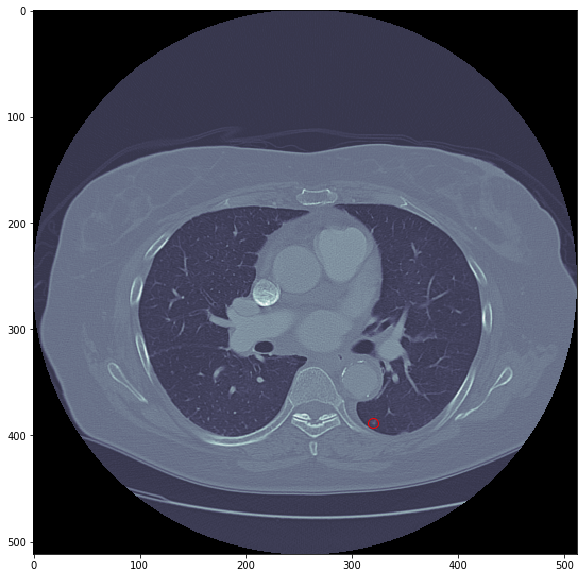

In [130]:
current_series = series[1]
xml_path = current_series.xml_path
xml_info = parse_xml_file(xml_path)
current_series.set_xml_info(xml_info)

roi = current_series.xml_info.annotations[0].nodules[0].rois[0]

print roi.z
print roi.roi_xy
print roi.roi_rect
print roi.roi_centroid


image = False
for i in range (0,len(current_series.dicom_image_paths)):
    ds = current_series.read_dicom_image(i)
    if(ds.SliceLocation == roi.z):
        image = ds
        break


fig, ax = pyplot.subplots(figsize=(18, 10))
image_to_show = image.pixel_array
ax.imshow(image.pixel_array, cmap=pyplot.cm.bone)

print image.pixel_array.shape
roi_x = roi.roi_xy[0][0]
roi_y = roi.roi_xy[0][1]


ax.plot([roi_x],[roi_y], 'ro',  markersize=10, markerfacecolor='none', markeredgecolor='r')

print( current_series.dicom_image_paths[0])
pyplot.show()


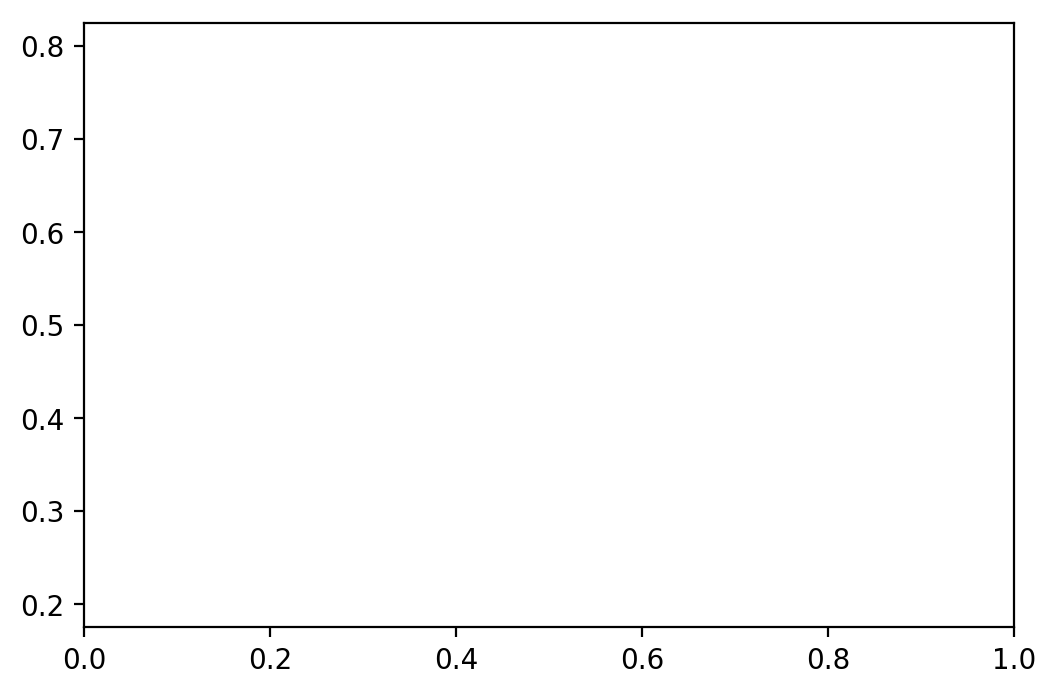

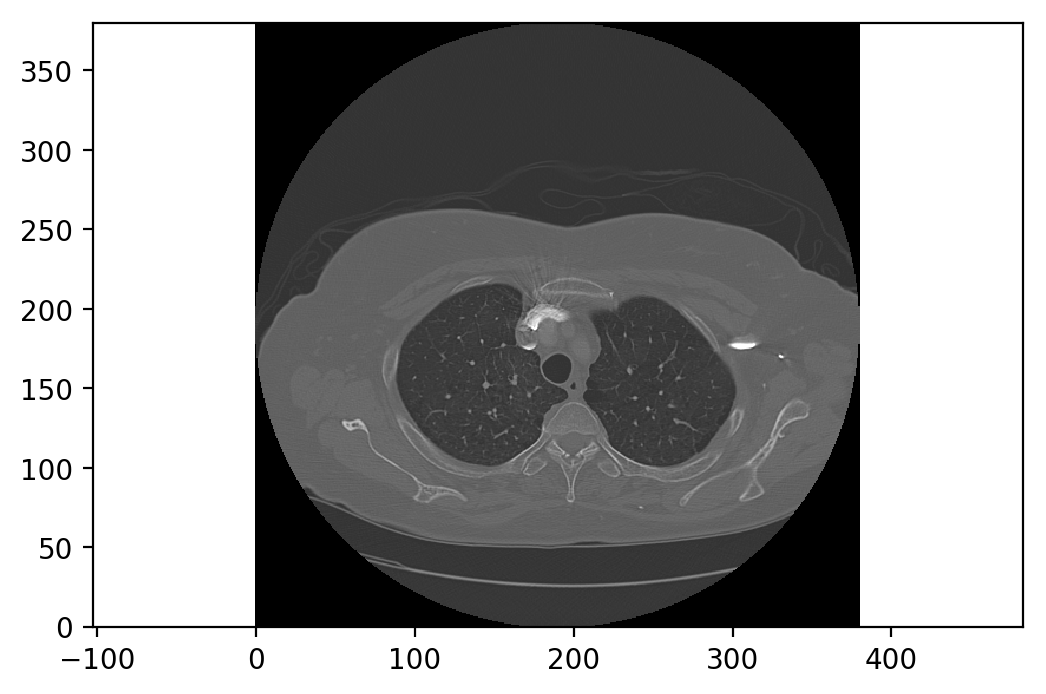

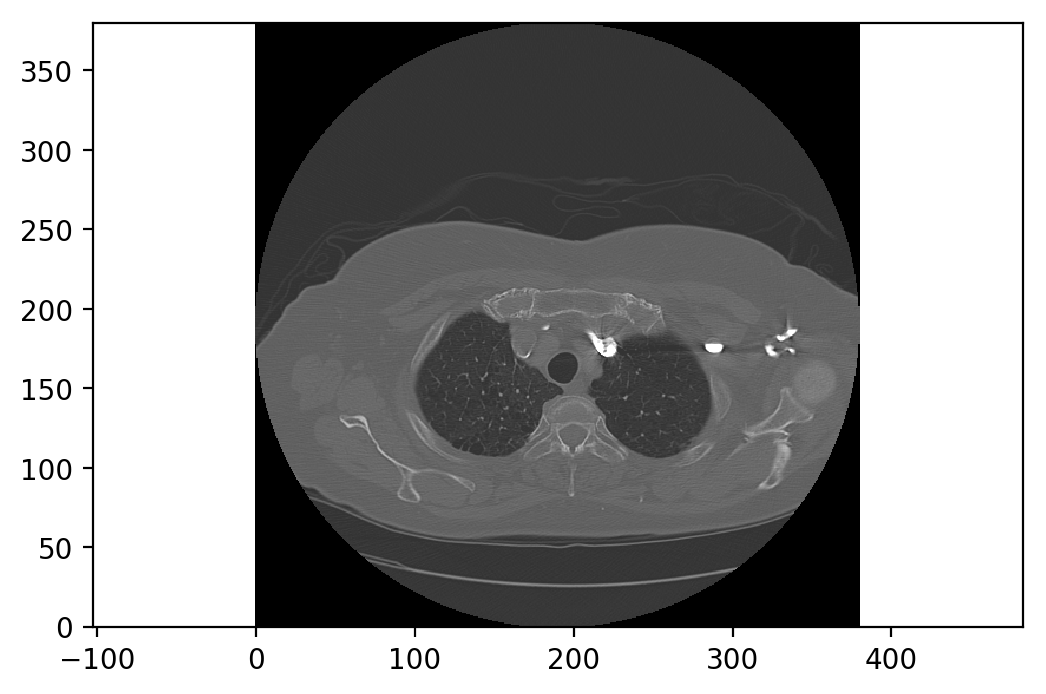

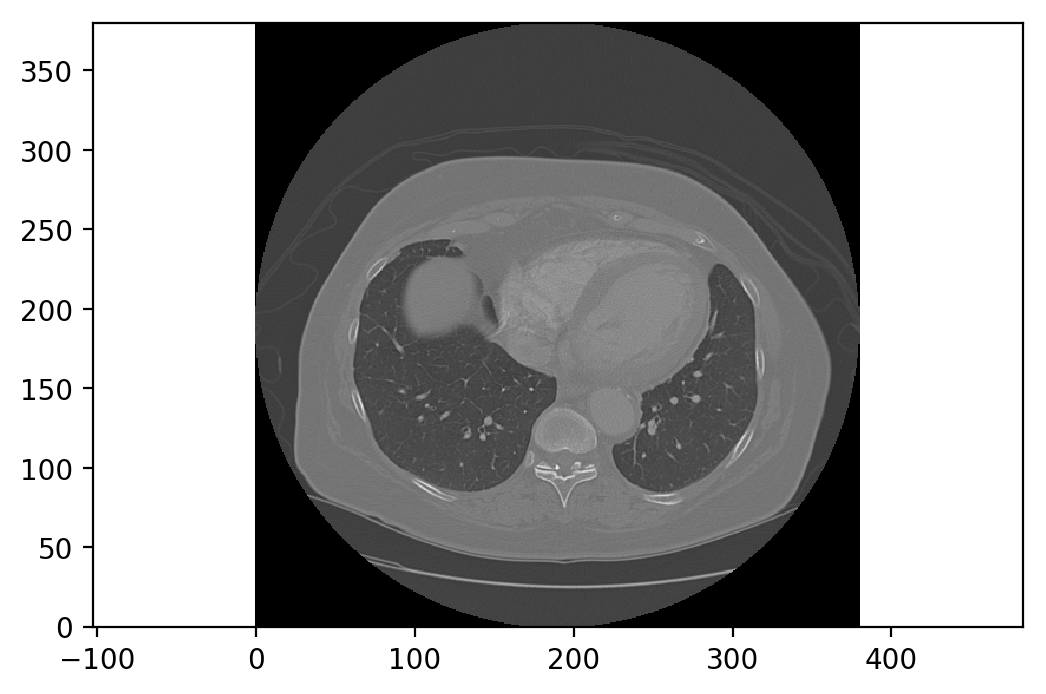

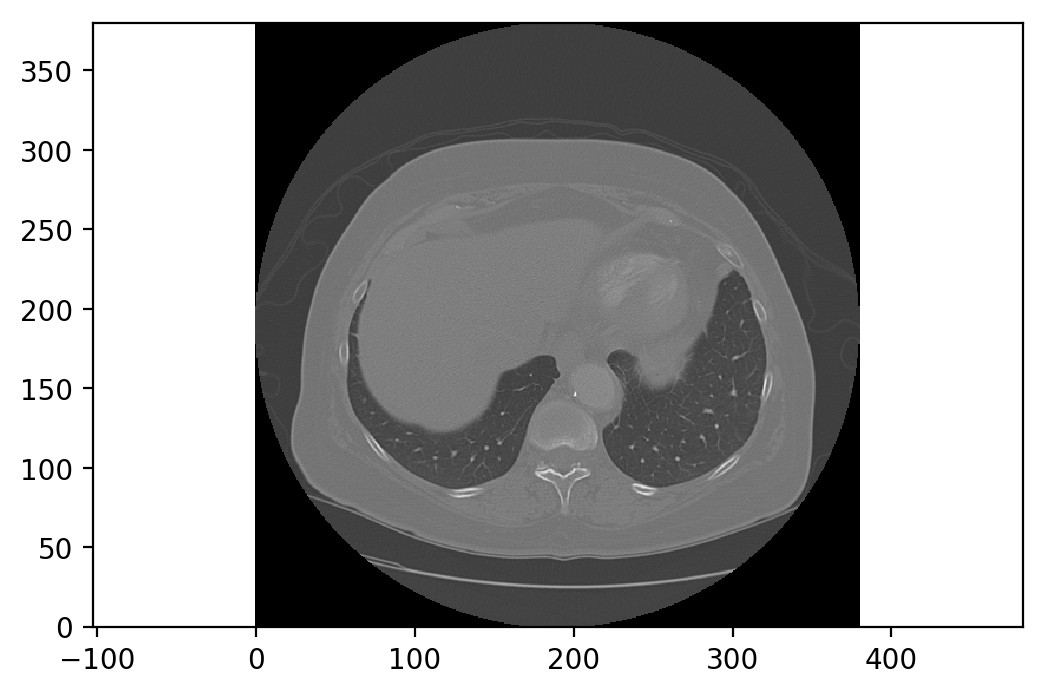

IndexError: index 185 is out of bounds for axis 2 with size 129

In [133]:
lstFilesDCM = series[1].dicom_image_paths
#print lstFilesDCM
# Get ref file
RefDs = dicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  
    
pyplot.figure(dpi=200)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 80]))

pyplot.show()

pyplot.figure(dpi=200)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 79]))

pyplot.show()

pyplot.figure(dpi=200)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 78]))

pyplot.show()

pyplot.figure(dpi=200)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 77]))

pyplot.show()

pyplot.figure(dpi=200)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 185]))

pyplot.show()

In [134]:
PathDicom=series[3].folder_path
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
#imageData = vtk.vtkImageData()

dims = imageData.GetDimensions()
 
imageData.SetDimensions(dims[0], dims[1], dims[2])

if vtk.VTK_MAJOR_VERSION <= 5:
    imageData.SetNumberOfScalarComponents(1)
    imageData.SetScalarTypeToDouble()
else:
    imageData.AllocateScalars(vtk.VTK_DOUBLE, 1)
 
# Fill every entry of the image data with "2.0"
for z in range(dims[2]):
    for y in range(dims[1]):
        for x in range(dims[0]):
            imageData.SetScalarComponentFromDouble(x, y, z, 0, 2.0)
 


filename = "writeImageData.vti"

writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName(filename)
if vtk.VTK_MAJOR_VERSION <= 5:
    writer.SetInputConnection(imageData.GetProducerPort())
else:
    writer.SetInputData(imageData)
writer.Write()
 
# Read the file (to test that it was written correctly)
reader = vtk.vtkXMLImageDataReader()
reader.SetFileName(filename)
reader.Update()
 
# Convert the image to a polydata
imageDataGeometryFilter = vtk.vtkImageDataGeometryFilter()
imageDataGeometryFilter.SetInputConnection(reader.GetOutputPort())
imageDataGeometryFilter.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(imageDataGeometryFilter.GetOutputPort())
 
actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetPointSize(3)
 
# Setup rendering
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1,1,1)
renderer.ResetCamera()
 
renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)
 
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
 
renderWindowInteractor.SetRenderWindow(renderWindow)
renderWindowInteractor.Initialize()
renderWindowInteractor.Start()

















'''
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
print(pointData)
arrayData = pointData.GetArray(0)

# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')



pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 80]))
pyplot.show()'''

"\n# Get the 'vtkPointData' object from the 'vtkImageData' object\npointData = imageData.GetPointData()\n# Ensure that only one array exists within the 'vtkPointData' object\nassert (pointData.GetNumberOfArrays()==1)\n# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function\nprint(pointData)\narrayData = pointData.GetArray(0)\n\n# Convert the `vtkArray` to a NumPy array\nArrayDicom = numpy_support.vtk_to_numpy(arrayData)\n# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'\nArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')\n\n\n\npyplot.axes().set_aspect('equal', 'datalim')\npyplot.set_cmap(pyplot.gray())\npyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 80]))\npyplot.show()"